In [2]:
import os, platform, sys, h5py
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, FloatSlider, Checkbox, FloatRangeSlider

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


Out of 196 simulations, 0 did not converge...


/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in log10


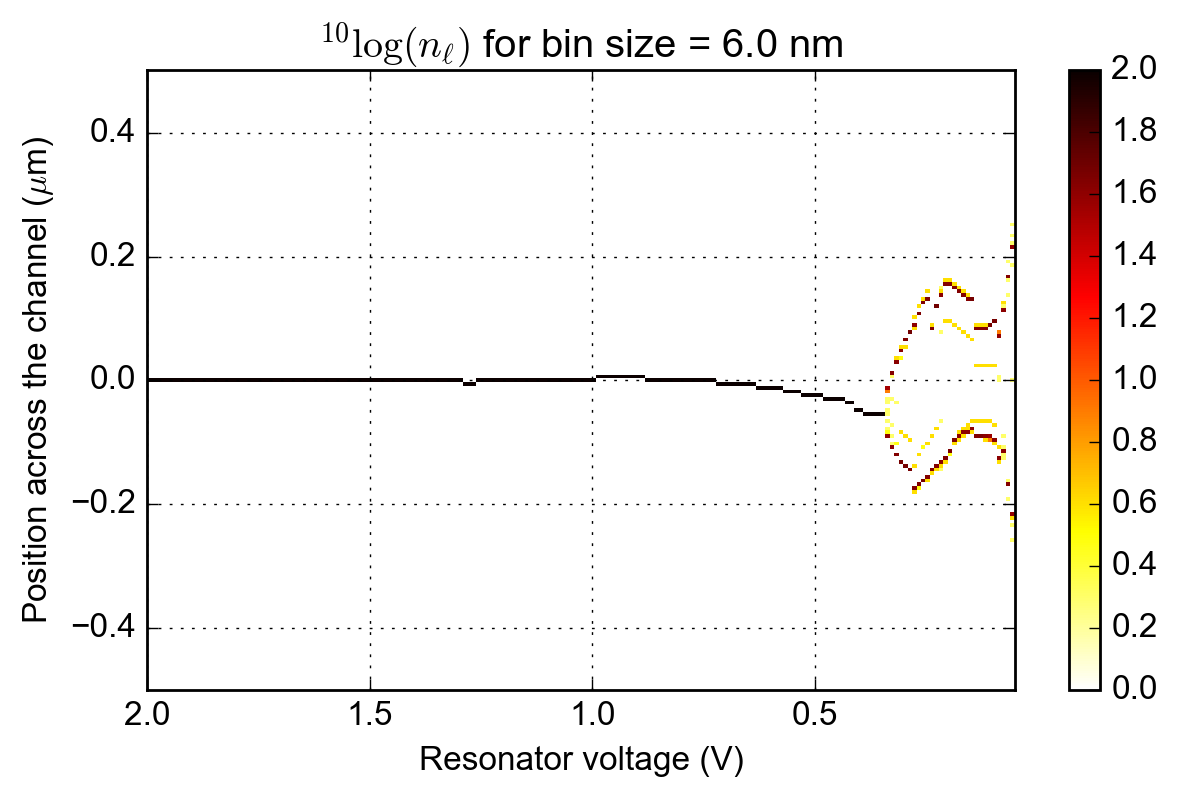

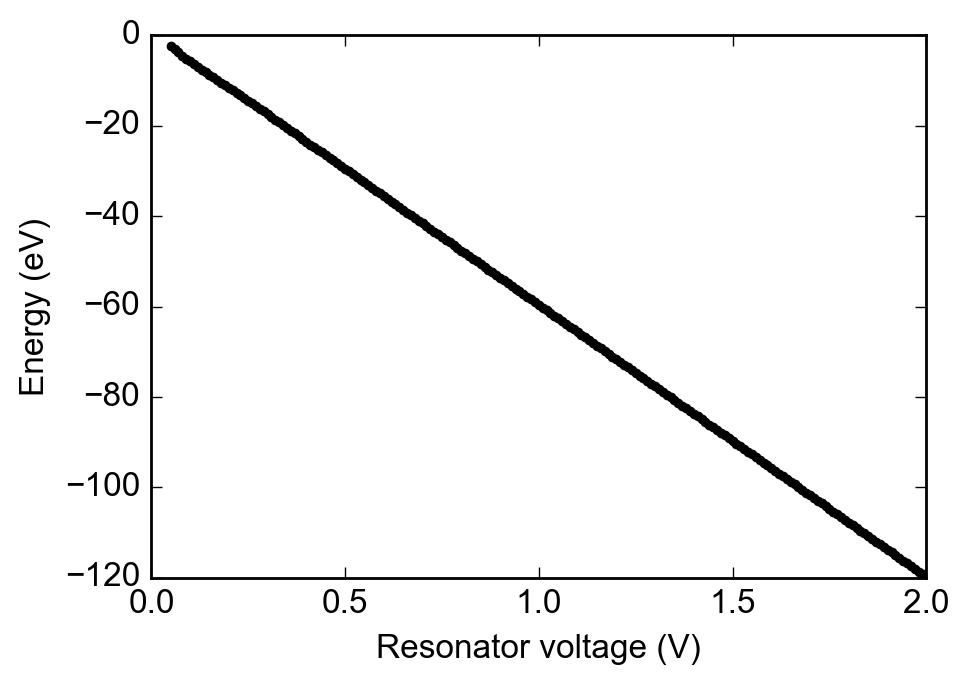

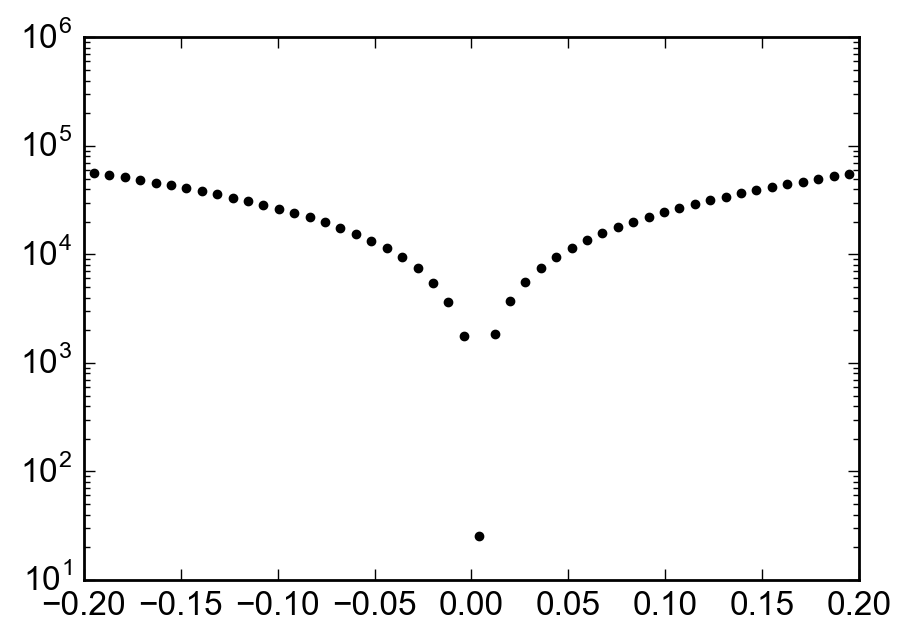

In [14]:
save_path = r"/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Resonator"
sub_dir = r"170117_130535_M018V2_resonator_Vsweep_100_electrons"

dbin = 0.006E-6
bins = np.arange(-0.50E-6, 0.50E-6+dbin, dbin)
converged = list()
energy = list()
save = False

with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
    k = 0
    for step in f.keys():
        if "step" in step:
            #print(step)
            electron_ri = f[step + "/electron_final_coordinates"][()]
            xi, yi = anneal.r2xy(electron_ri)
            energy.append(f[step+"/energy"][()])
            
            
            valid_solution = f[step + "/solution_converged"][()]
            converged.append(valid_solution)

            if valid_solution:
                electron_hist, bin_edges = np.histogram(xi, bins=bins)
            else:
                electron_hist = np.zeros(len(electron_hist))

            if k == 0:
                electron_histogram = electron_hist
            else:
                electron_histogram = np.vstack((electron_histogram, electron_hist))

            k += 1

    #print("Ja!")
    Vres = f["Vres"][()]
    xpoints = f["xpoints"][()]
    potential = f["electrostatic_potential"][()]

print("Out of %d simulations, %d did not converge..." % (len(Vres), len(Vres) - np.sum(converged)))

fig = plt.figure(figsize=(7.,4.))
common.configure_axes(12)
plt.pcolormesh(Vres, bins[:-1]*1E6, np.log10(electron_histogram.T), vmin=0, vmax=2.0, cmap=plt.cm.hot_r)
plt.colorbar()
plt.xlim(Vres[0], Vres[-1])
plt.ylim(np.min(bins)*1E6, np.max(bins)*1E6)
plt.xlabel("Resonator voltage (V)")
plt.ylabel("Position across the channel ($\mu$m)")
plt.title(r"$^{10}\log (n_\ell)$ for bin size = %.1f nm"%(dbin*1E9))
plt.grid()

if save:
    common.save_figure(fig, os.path.join(save_path, sub_dir))

fig2 = plt.figure(figsize=(5.,3.5))
plt.plot(Vres, np.array(energy), '.-k')
plt.ylabel("Energy (eV)")
plt.xlabel("Resonator voltage (V)")

from scipy.interpolate import UnivariateSpline
interpolator = UnivariateSpline(xpoints, potential, k=3, s=0.005, ext=3)
derivative = interpolator.derivative(n=1)

fig3 = plt.figure(figsize=(5.,3.5))
plt.plot(xpoints*1E6, np.abs(derivative(xpoints)), '.k')
plt.xlim(-0.2, 0.2)
plt.yscale('log')


In [32]:
PP = anneal.PostProcess()
master_dir = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Variable density"

def load_from_file(sub_dir):
    electrons_in_trap = list()
    energy = list()
    with h5py.File(os.path.join(os.path.join(master_dir, sub_dir), "Results.h5"), "r") as f:
        for k,step in enumerate(f.keys()):
            electrons_in_trap.append(f[step+"/electrons_in_trap"][()])
            energy.append(f[step+"/energy"][()])

            if k == 0: 
                coefficients = f[step+"/potential_coefficients"][()]
                N_electrons = np.int(len(f[step+"/electron_initial_coordinates"])/2.)
                ns_init = PP.get_electron_density(f[step+"/electron_final_coordinates"][()])
            else:
                coefficients = np.vstack((coefficients, f[step+"/potential_coefficients"][()]))
                
    return coefficients, electrons_in_trap, energy, ns_init

In [73]:
sub_dir = "161101_20_electrons"
coefficients, electrons_in_trap, energy, ns_init = load_from_file(sub_dir)
Vtrap = coefficients[:,1]

The electron density in the figure above is 1.926e+12 m^-2


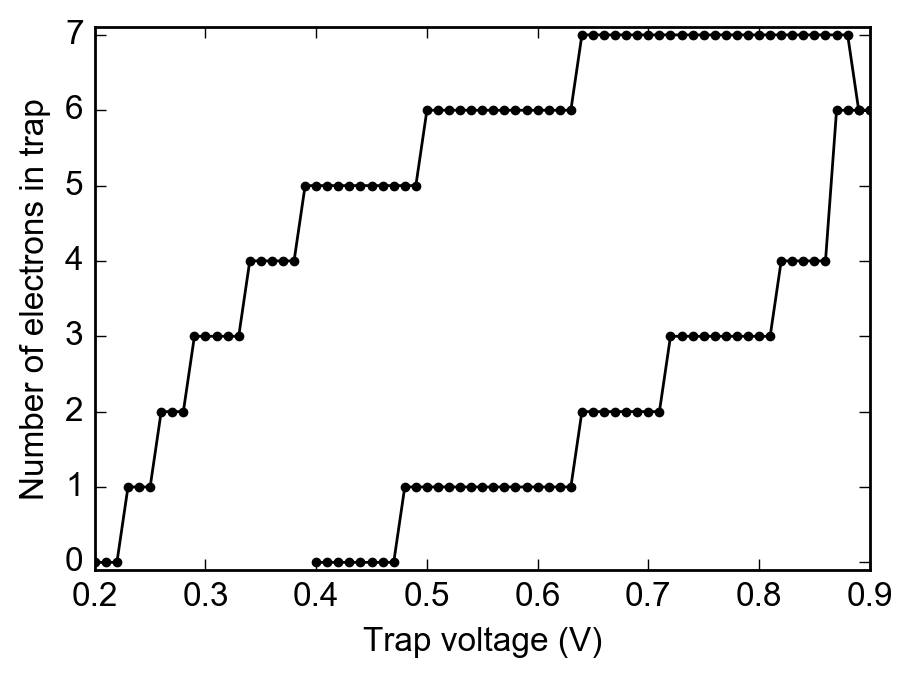

In [74]:
fig = plt.figure(figsize=(5.,3.5))
common.configure_axes(12)
plt.plot(Vtrap, electrons_in_trap, '.-k')
plt.ylabel("Number of electrons in trap")
plt.xlabel("Trap voltage (V)")
plt.ylim(-0.1, np.max(electrons_in_trap)+0.1)
common.save_figure(fig, save_path=os.path.join(master_dir, sub_dir))

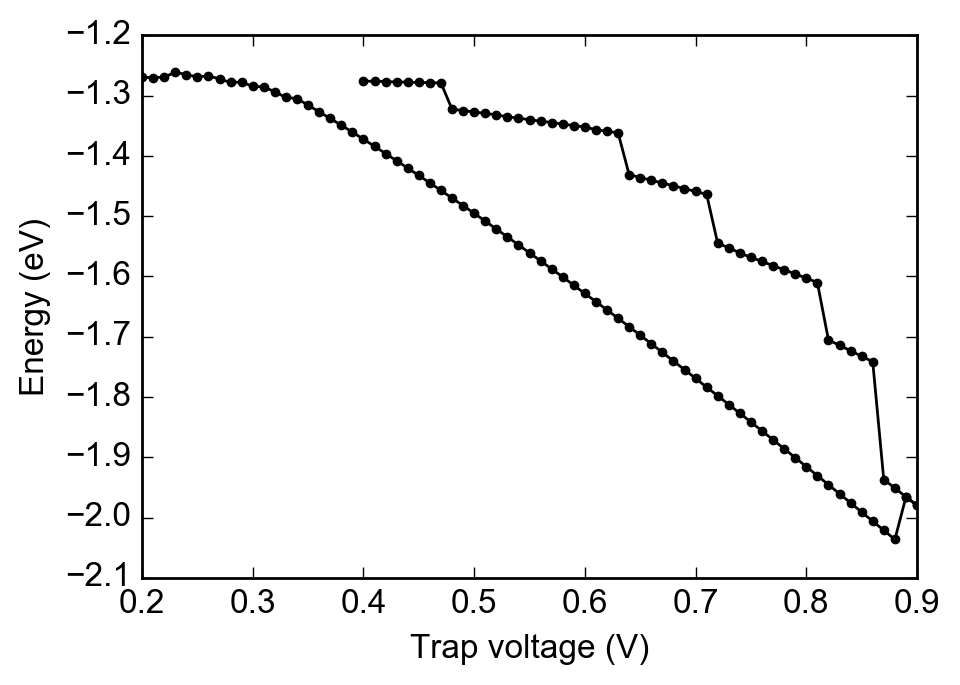

In [75]:
fig = plt.figure(figsize=(5.,3.5))
plt.plot(Vtrap, energy, '.-k')
plt.ylabel("Energy (eV)")
plt.xlabel("Trap voltage (V)")
common.save_figure(fig, save_path=os.path.join(master_dir, sub_dir))

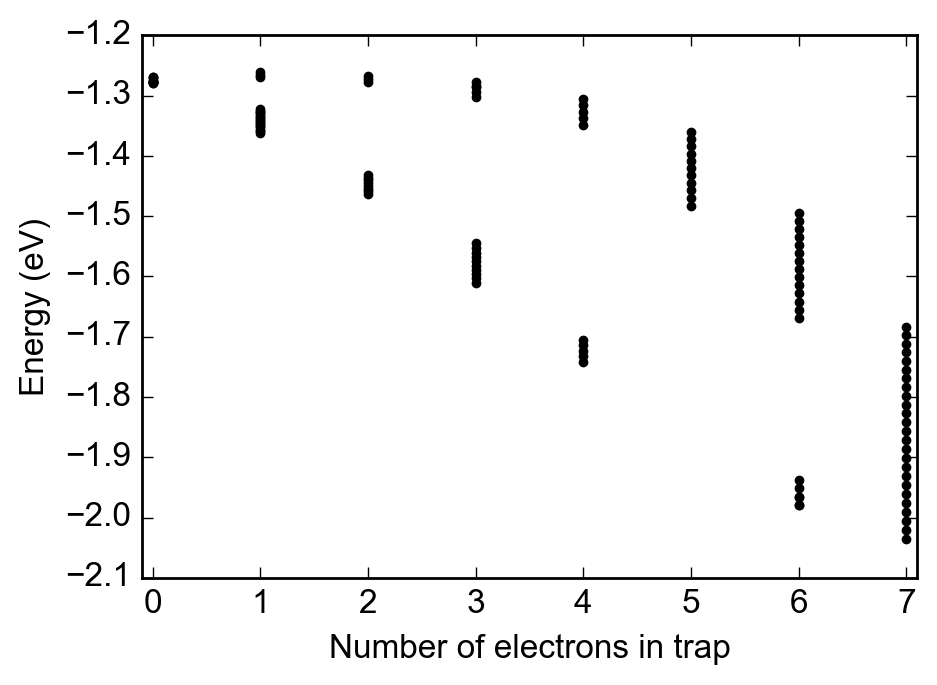

In [76]:
fig = plt.figure(figsize=(5.,3.5))
plt.plot(electrons_in_trap, energy, '.k')
plt.ylabel("Energy (eV)")
plt.xlabel("Number of electrons in trap")
plt.xlim(-0.1, np.max(electrons_in_trap)+0.1)
common.save_figure(fig, save_path=os.path.join(master_dir, sub_dir))